In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["font.size"] = 20

# Tutorial: Fitting a Model to Data

If you’re reading this right now then you’re probably interested in using **emcee3** to fit a model to some noisy data. On this page, I’ll demonstrate how you might do this in the simplest non-trivial model that I could think of: fitting a line to data when you don’t believe the error bars on your data. The interested reader should check out [Hogg, Bovy & Lang (2010)](http://arxiv.org/abs/1008.4686) for a much more complete discussion of how to fit a line to data in The Real World™ and why MCMC might come in handy.

This tutorial was automatically generated using an IPython notebook that can be downloaded [here](../../_static/notebooks/line.ipynb).

## Generating fake data from the model

When you approach a new problem, the first step is generally to write down the likelihood function (the probability of a dataset given the model parameters). This is equivalent to describing the generative procedure for the data. In this case, we’re going to consider a linear model where the quoted uncertainties are underestimated by a constant fractional amount. You can generate a synthetic dataset from this model:

In [2]:
import numpy as np
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

This synthetic dataset (with the underestimated error bars) will look something like:

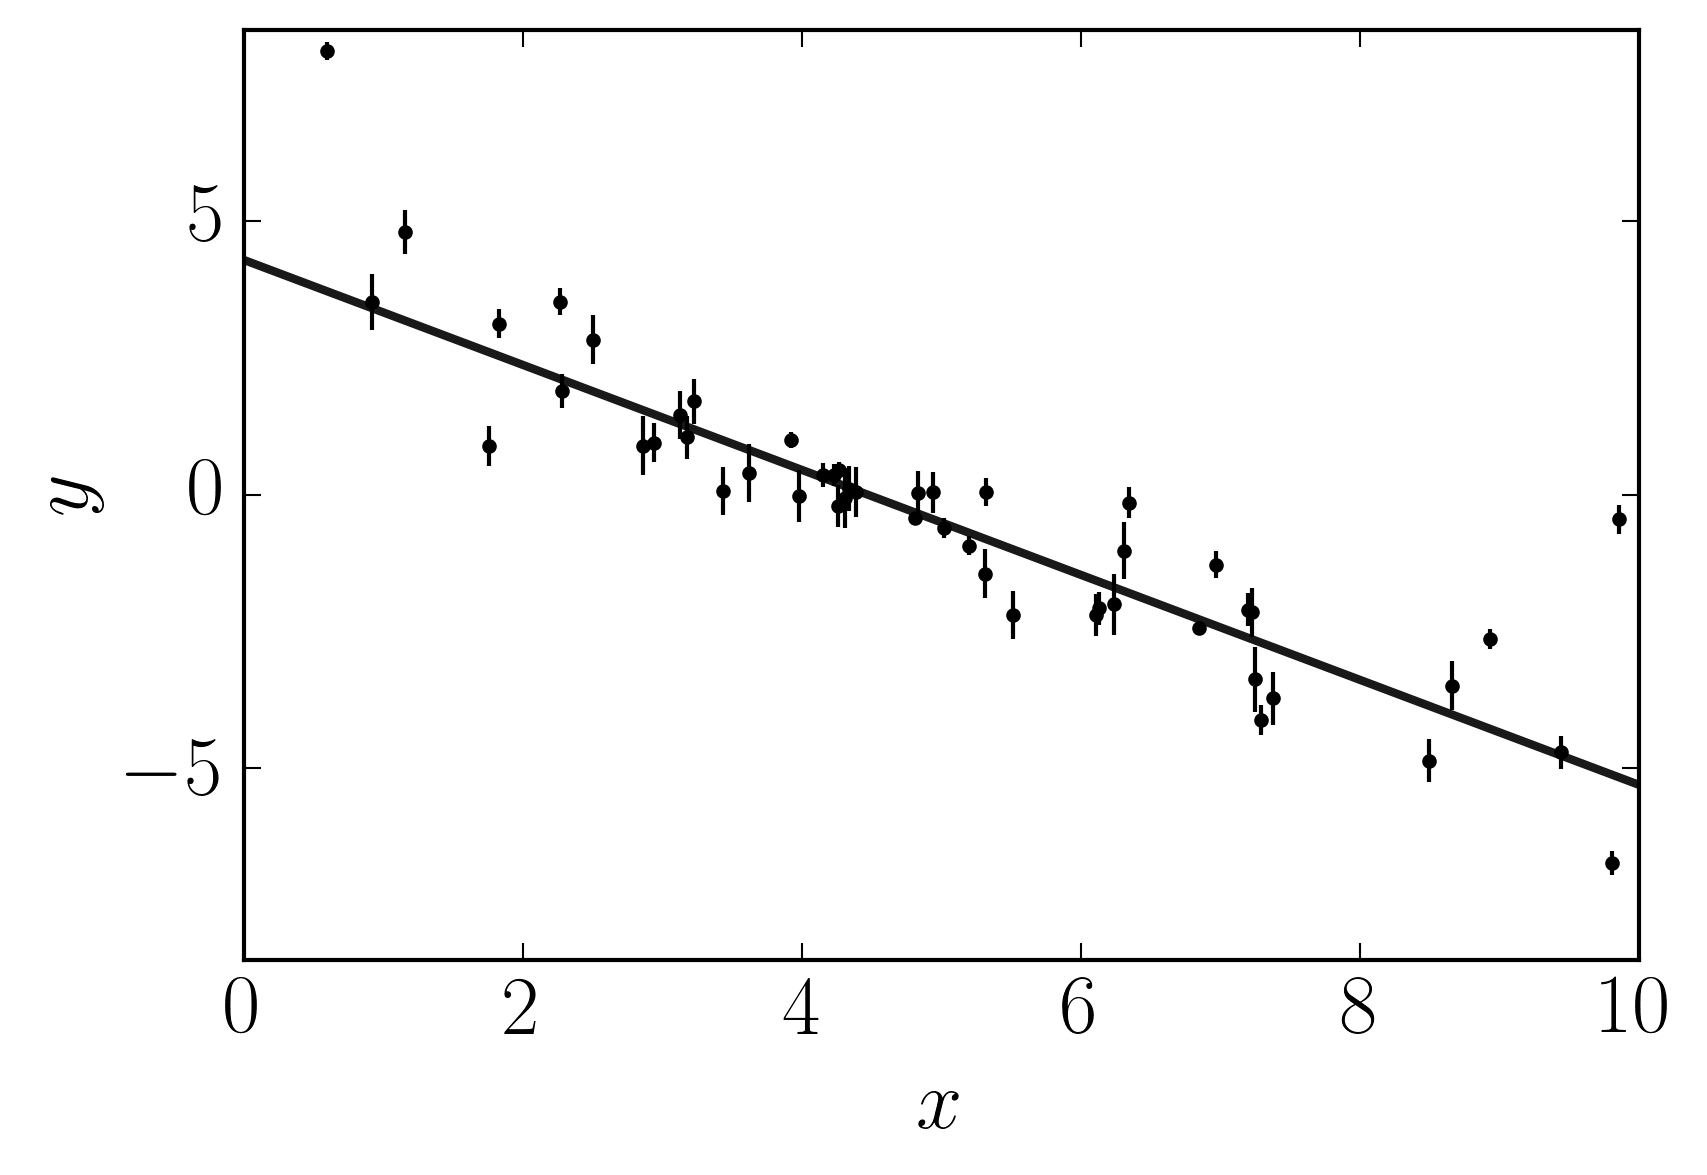

In [3]:
import matplotlib.pyplot as pl

x0 = np.linspace(0, 10, 2)
def plot_data():
    pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    pl.plot(x0, m_true * x0 + b_true, "k", lw=2, alpha=0.9)
    pl.ylim(-8.5, 8.5)
    pl.xlabel("$x$")
    pl.ylabel("$y$");
    
plot_data()

The true model is shown as the thick black line and the effect of the underestimated uncertainties is obvious when you look at this figure.

## Maximum-likelihood solution

The standard method for fitting a line to these data is linear least squares. This is equivalent to assuming that the uncertainties on each $y$ measurement are Gaussian, independent, and known. Linear least squares is appealing because solving for the parameters—and their associated uncertainties—is simply a linear algebraic operation. The least squares (or maximum likelihood) solution for these data can be computed in Python as follows:

In [4]:
A = np.vstack((np.ones_like(x), x)).T
ivar = 1.0 / yerr**2
cov = np.linalg.inv(np.dot(A.T, ivar[:, None] * A))
b_ls, m_ls = np.dot(cov, np.dot(A.T, ivar * y))

This result gives the following constraints on the slope and intercept parameters:

In [5]:
from IPython.display import display, Math
display(Math(r"m_\mathrm{{LS}} = {0:.2f} \pm {1:.2f}".format(m_ls, np.sqrt(cov[1, 1]))))
display(Math(r"b_\mathrm{{LS}} = {0:.2f} \pm {1:.2f}".format(b_ls, np.sqrt(cov[0, 0]))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

And we can plot the maximum likelihood line on top of the data points and compare it to the true line that was used to generate the data:

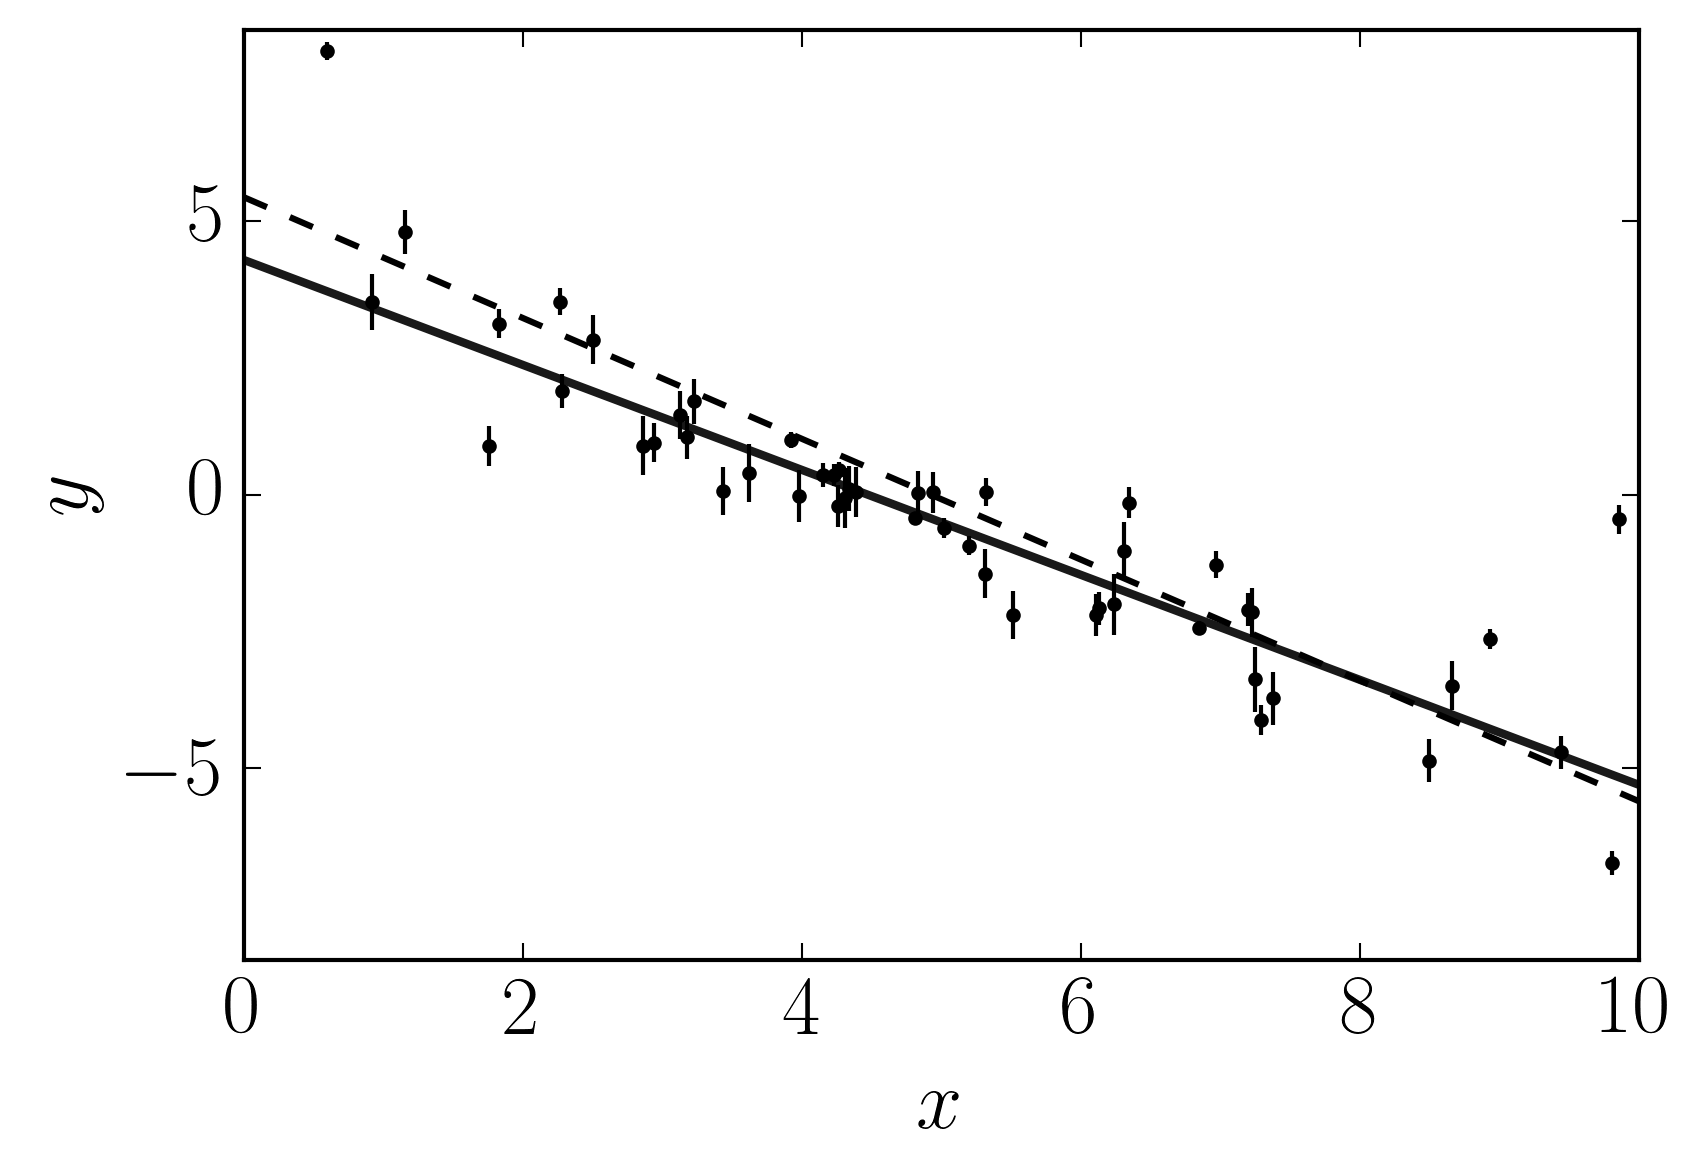

In [6]:
plot_data()
pl.plot(x0, m_ls * x0 + b_ls, "--k", lw=1.5);

This isn’t an unreasonable result but the uncertainties on the slope and intercept seem a little small (because of the small error bars on most of the data points).

## Building the probabilistic model

If we relax our above assumption that we know all the uncertainties correctly and model them instead, we will find the following likelihood function:  

$$\ln\,p(y\,|\,x,\sigma,m,b,f) =
-\frac{1}{2} \sum_n \left[
  \frac{(y_n-m\,x_n-b)^2}{s_n^2}
  + \ln \left ( 2\pi\,s_n^2 \right )
\right]$$

where

$$s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .$$

Unfortunately, under this model, the isn't an analytic maximum likelihood solution like least squares. This time, we would need to optimize (maximize) this function numerically using something like the [scipy.optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html) module but that's a discussion for another time.

Let's ask a different question instead: how do we estimate the uncertainties on $m$ and $b$? What's more, we probably don't really care too much about the value of $f$ but we do want to propagate any uncertainties about its value to our final estimates of $m$ and $b$. This is where MCMC comes in.

This isn't the place to get into the details of why you might want to use MCMC in your research but it is worth commenting that a common reason is that you would like to marginalize over some "nuisance parameters" and find an estimate of the posterior probability function (the distribution of parameters that is consistent with your dataset) for others. MCMC lets you do both of these things in one fell swoop! You need to start by writing down the posterior probability function (up to a constant):

$$p (m,b,f\,|\,x,y,\sigma) \propto p(m,b,f)\,p(y\,|\,x,\sigma,m,b,f) \quad .$$

We have already, written down the (log-)likelihood function

$$p(y\,|\,x,\sigma,m,b,f)$$

so the missing component is the "prior" function

$$p(m,b,f) \quad .$$

This function encodes any previous knowledge that we have about the parameters: results from other experiments, physically acceptable ranges, etc. It is necessary that you write down priors if you're going to use MCMC because all that MCMC does is draw samples from a probability distribution and you want that to be a probability distribution for your parameters. This is important: **you cannot draw parameter samples from your likelihood function**. This is because a likelihood function is a probability distribution **over datasets** so, conditioned on model parameters, you can draw representative datasets (as demonstrated at the beginning of this exercise) but you cannot draw parameter samples.

In this example, we'll use uniform (so-called "uninformative") priors on $m$, $b$ and the logarithm of $f$. For example, we'll use the following conservative prior on $m$:

$$p(m) = \left \{\begin{array}{ll}
1 / 5.5 \,, & \mbox{if}\,-5 < m < 1/2 \\
0 \,, & \mbox{otherwise}
\end{array}
\right .$$

To implement this in **emcee3**, you would code these functions up and wrap them in an ``emcee3.SimpleModel`` object as implemented below. Take a minute to study this code and compare it to the equations from this section. If you're not familiar with object-oriented programming in Python, don't worry because it doesn't really get more complicated than this.

In [7]:
import emcee3

def log_prior_func(theta, x, y, yerr):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def log_likelihood_func(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

model = emcee3.SimpleModel(log_likelihood_func, log_prior_func, args=(x, y, yerr))

A few comments/questions about this code:

1. It's important that the two methods are called `lnpriorfn` and `lnlikefn` (and you need to implement both of them).
2. What is the `self` argument? What about `theta`?
3. Why am I returning `0.0` from `lnpriorfn` instead of something like `-log(5.5)`?

## Sampling from the posterior probability

After all this setup, it's easy to sample this probability distribution using **emcee3**. I'm not going to go into detail about how the algorithm works (you should [read the paper](http://arxiv.org/abs/1202.3665)) but the basic idea is that it takes an "ensemble" of "walkers" and updates the walkers' coordinates in parameter space. You repeat this update many times (storing all the updated coordintes) and this gives a list of samples $\theta$ from the probability distribution $p (m,b,f\,|\,x,y,\sigma)$.

To start, you need to choose the coordinates of the walkers in the initial ensemble. This can be hard and the quality of your results can (in practice) depend on this choice. In this example, we'll use 100 walkers and initialize them in a small Gaussian ball around a reasonable first guess (that I chose by looking at the data):

In [8]:
ndim, nwalkers = 3, 100
coords = np.array([-1.0, 4.0, -0.5]) + 1e-4*np.random.randn(nwalkers, ndim)
ensemble = emcee3.Ensemble(model, coords)

Note that the order of the parameters in the coordinate vectors should be the same as the order that you use in your implementation of `LinearModel` from above.

When we executed the above code snippet, each walker already computed the value of the probabilistic model at its coordinates in parameter space. Therefore, we can look at the values for the first walker:

In [9]:
print("The first walker has the coordinates: {0}".format(ensemble[0].coords))
print("and log prior={0:.3f}, log likelihood={1:.3f}, and log probability={2:.3f}"
      .format(ensemble[0].log_prior, ensemble[0].log_likelihood, ensemble[0].log_probability))

The first walker has the coordinates: [-1.00003548  4.00003916 -0.49998228]
and log prior=0.000, log likelihood=-47.991, and log probability=-47.991


Now, let's run 500 steps of MCMC (starting from this ensemble) and see what happens:

In [10]:
sampler = emcee3.Sampler()
sampler.run(ensemble, 500);

Let's plot the coordinates of the walkers as a function of step number in the chain (the chain is stored in the `coords` property on the sampler or it can be accessed more flexibly using the `get_coords()` function):

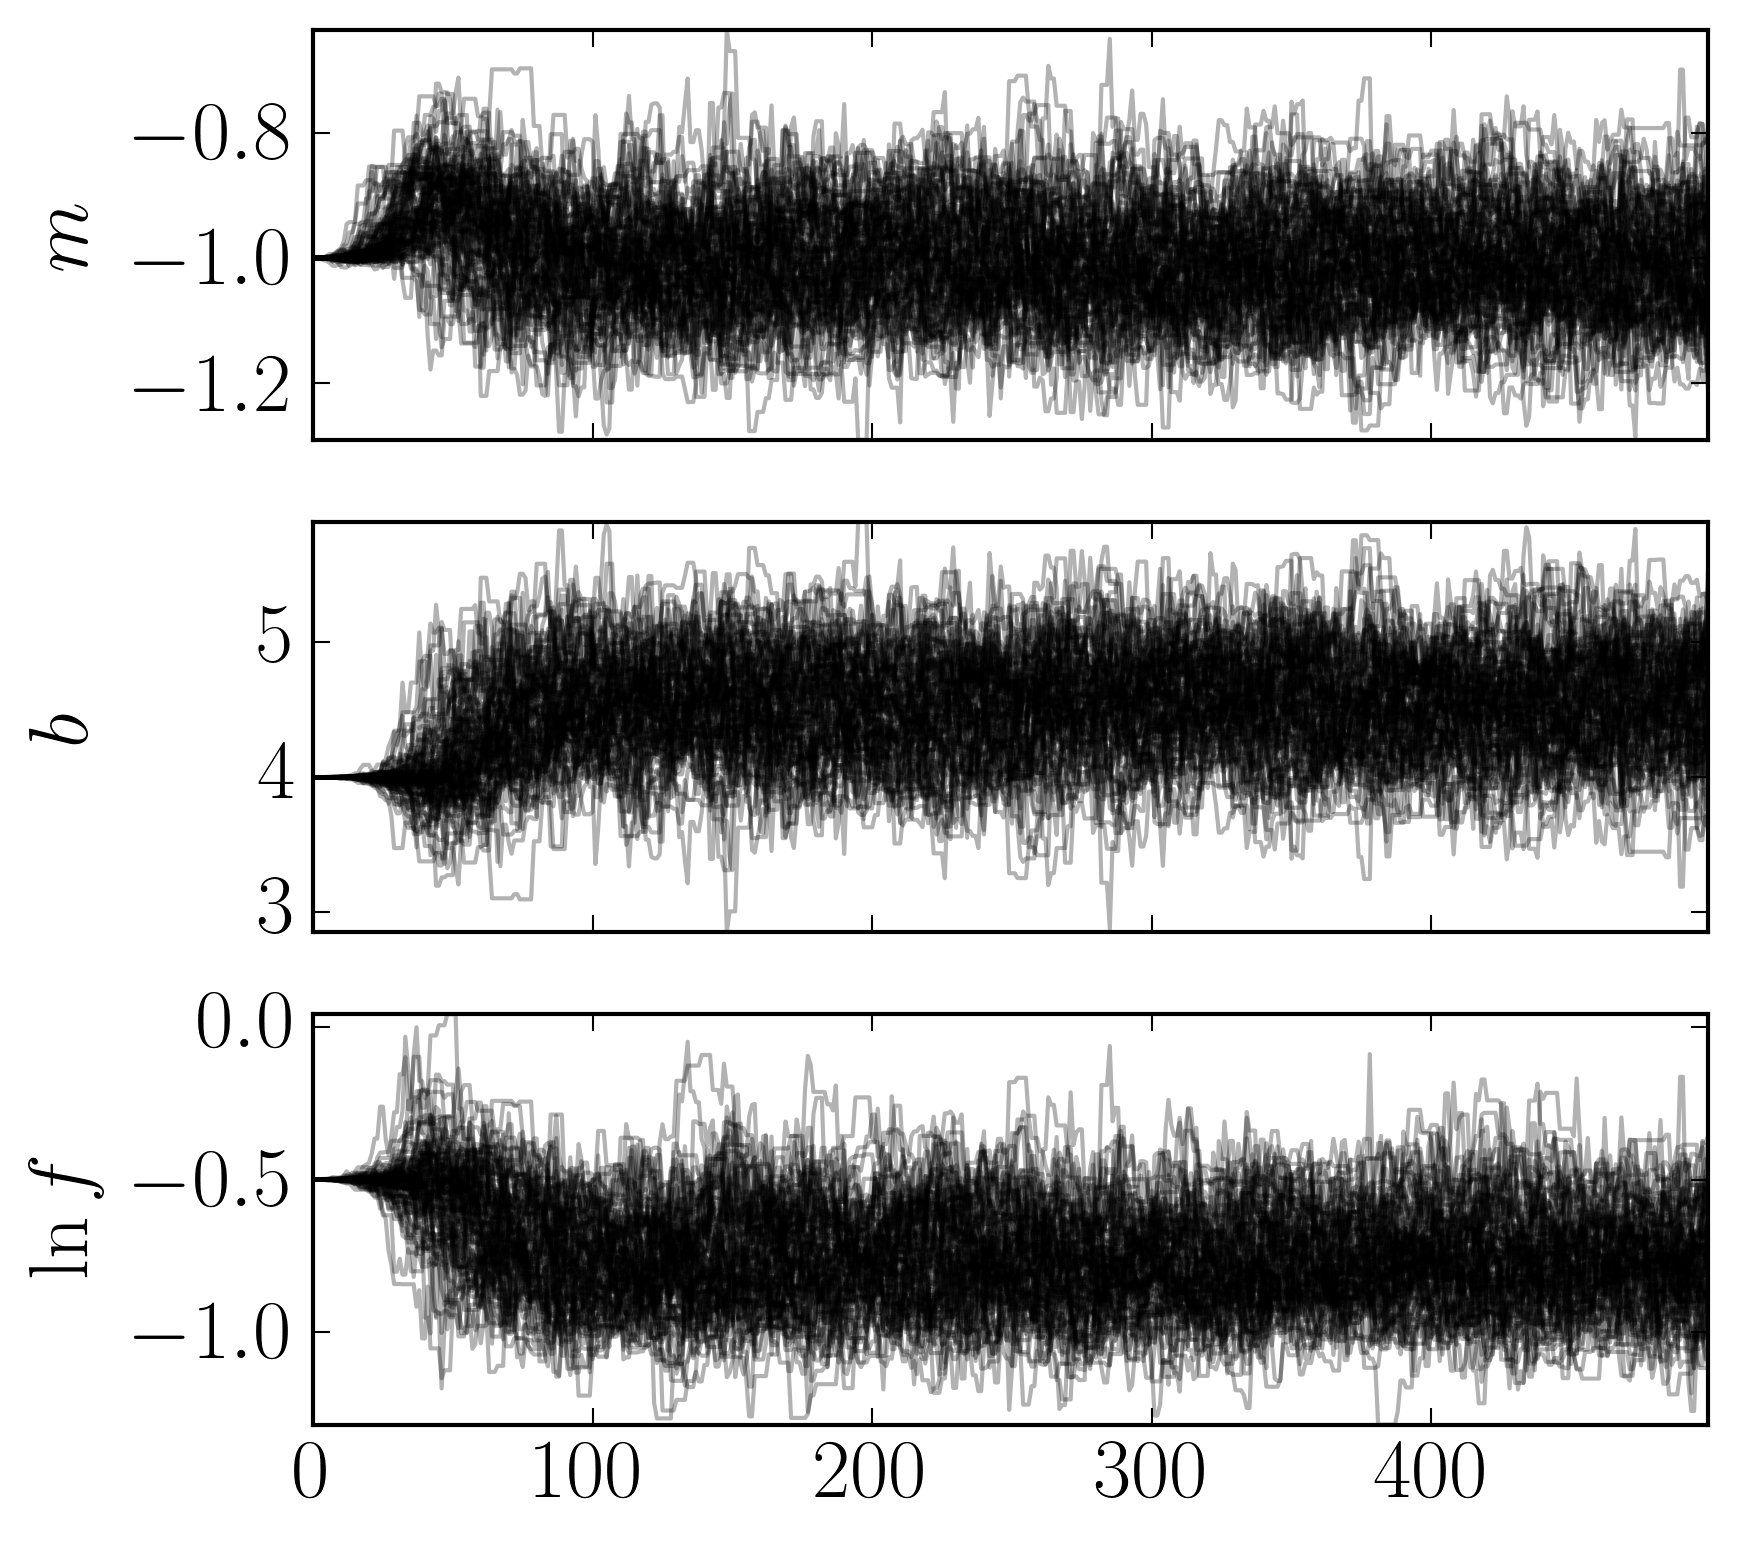

In [11]:
chain = sampler.get_coords()
fig, axes = pl.subplots(3, 1, sharex=True, figsize=(6, 6))
for k, nm in enumerate(["$m$", "$b$", r"$\ln f$"]):
    axes[k].plot(chain[:, :, k], "k", alpha=0.3)
    axes[k].locator_params(tight=True, nbins=6)
    axes[k].yaxis.set_label_coords(-0.15, 0.5)
    axes[k].set_ylabel(nm)

It looks like the chain converged after the first 100 steps so we'll discard those samples and plot the resulting parameter constraints using the [triangle.py](https://github.com/dfm/triangle.py) package (you might need to install it). Note the use of the `flat=True` argument in the `get_coords()` method. 

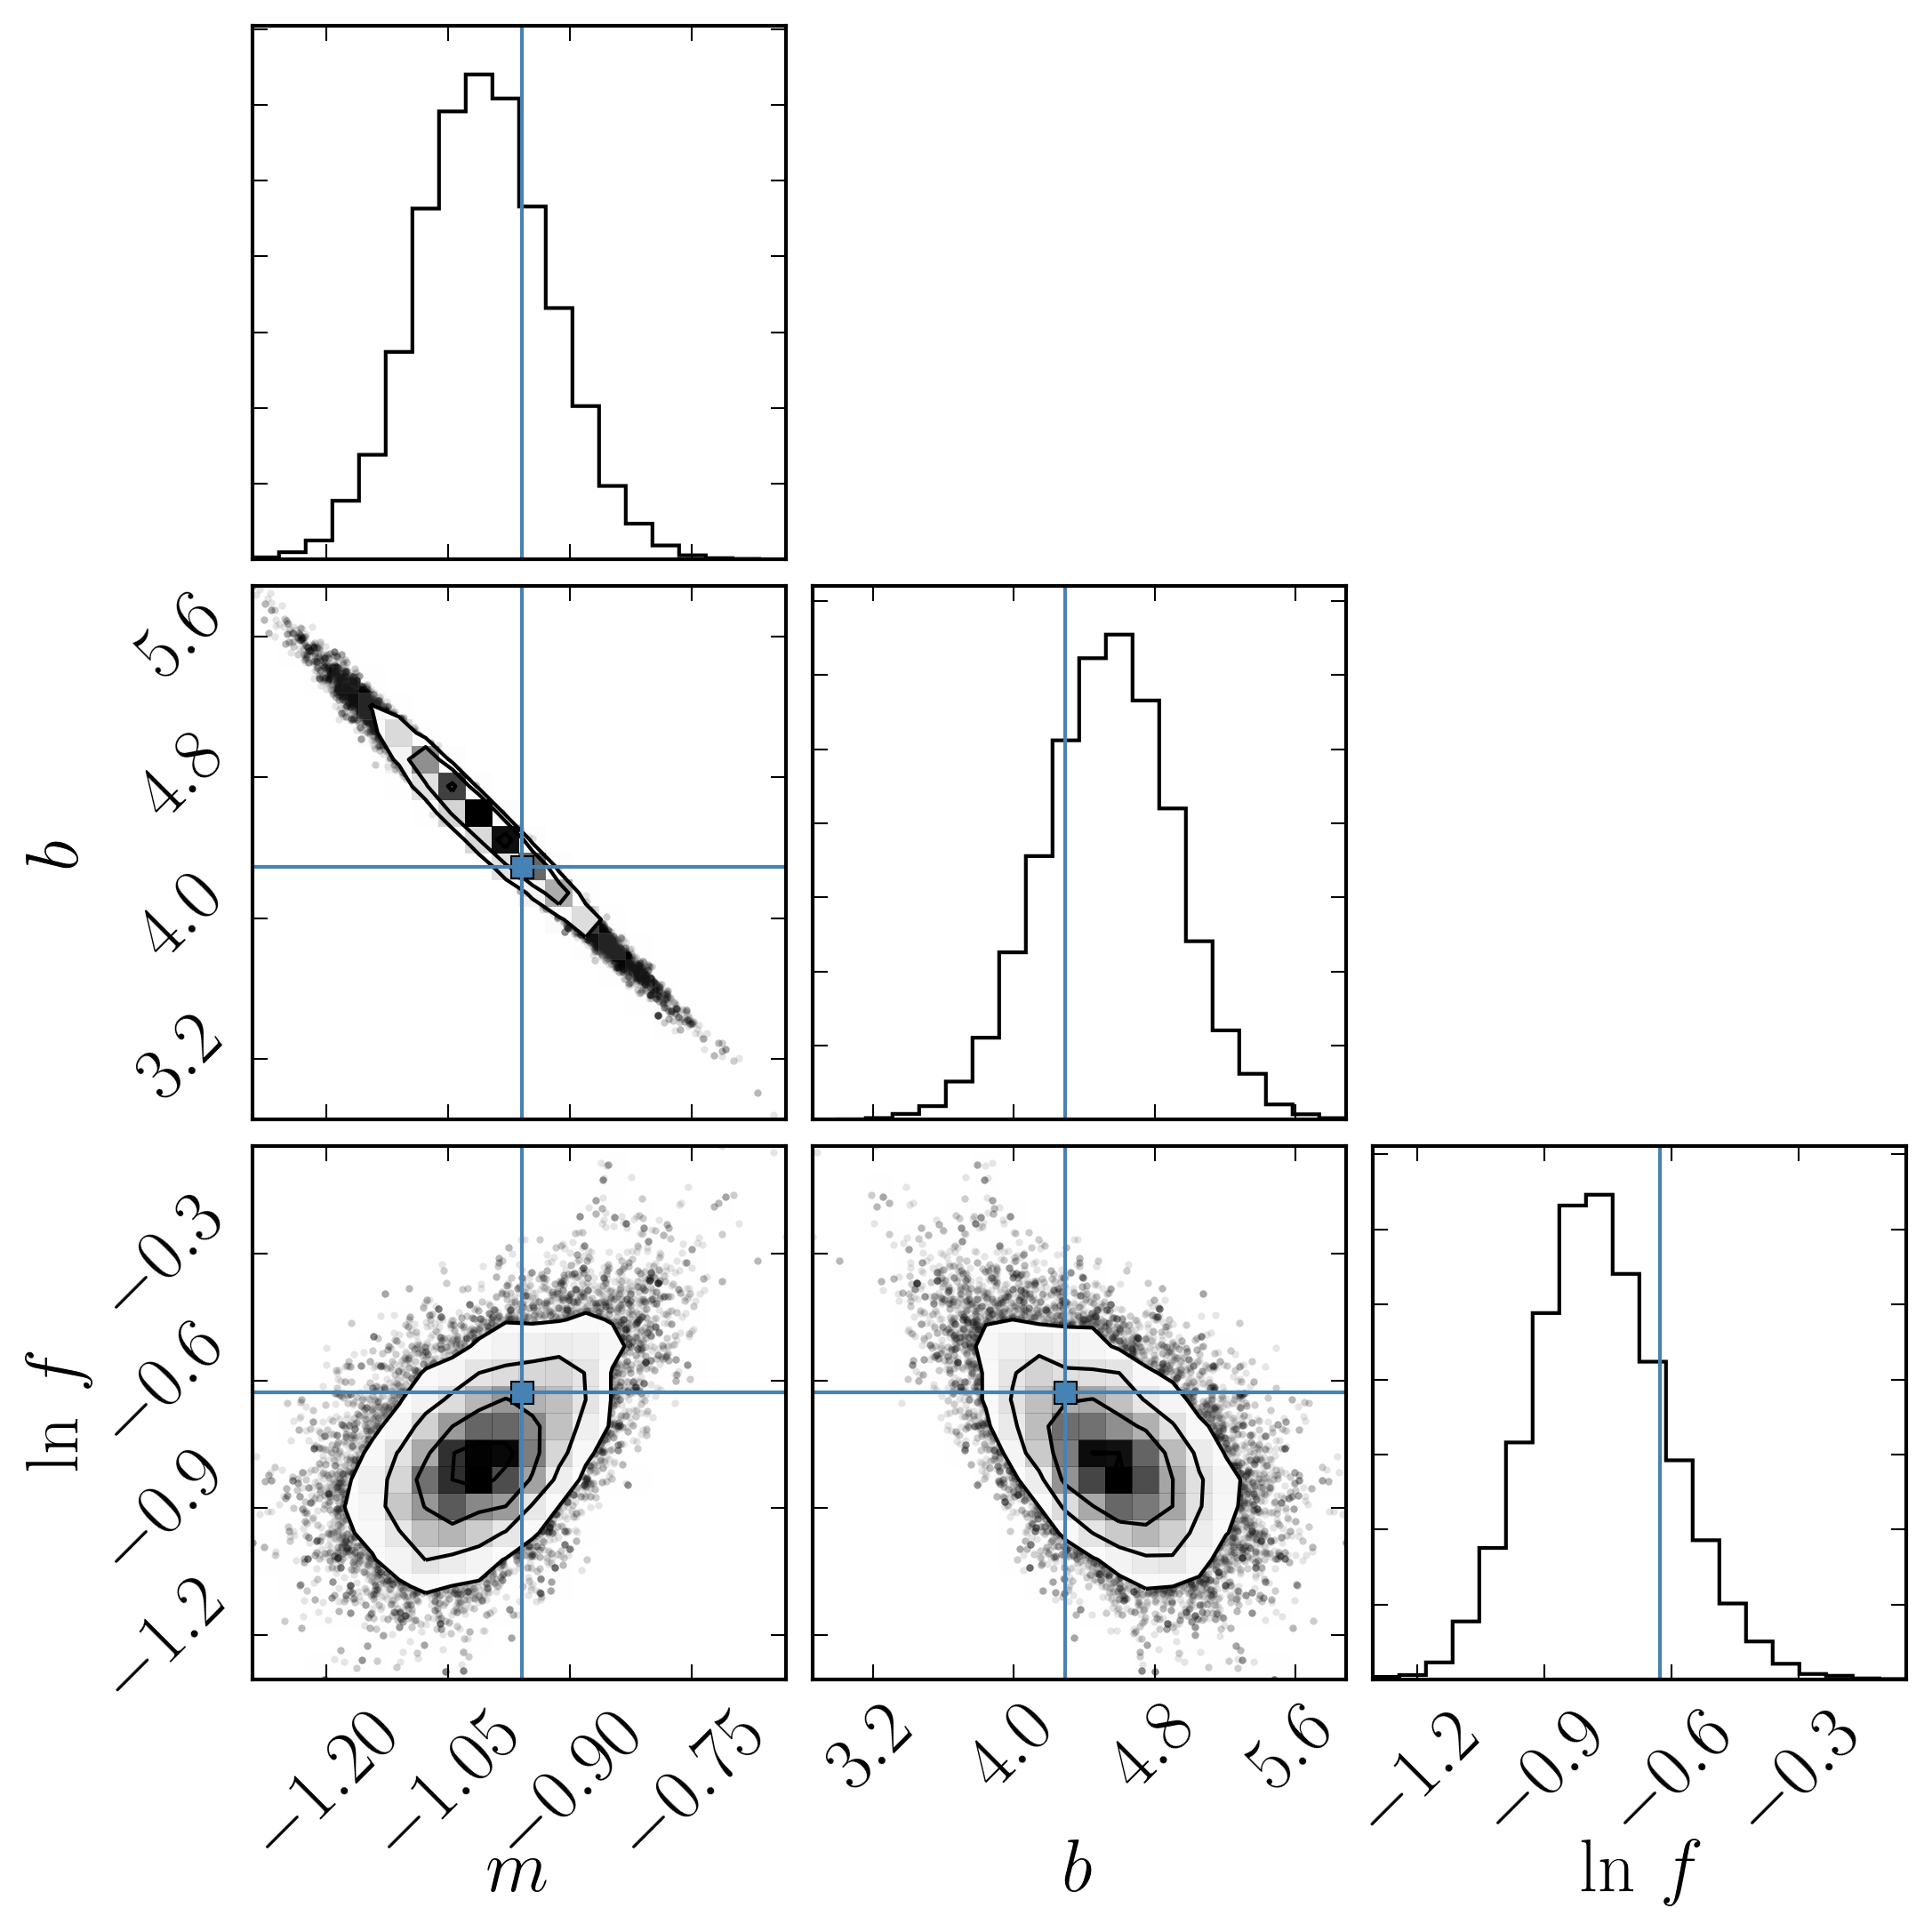

In [12]:
import corner
flatchain = sampler.get_coords(discard=100, flat=True)
corner.corner(flatchain, labels=["$m$", "$b$", "$\ln\,f$"],
              truths=[m_true, b_true, np.log(f_true)]);

This plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters. This is useful because it quickly demonstrates all of the covariances between parameters. Also, the way that you find the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain is to project the samples into that plane and then make an N-dimensional histogram. That means that the corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

Another good thing to plot is the projection of your results into the space of the observed data. To do this, you can choose a few (say 50 in this case) samples from the chain and plot them on top of the data points:

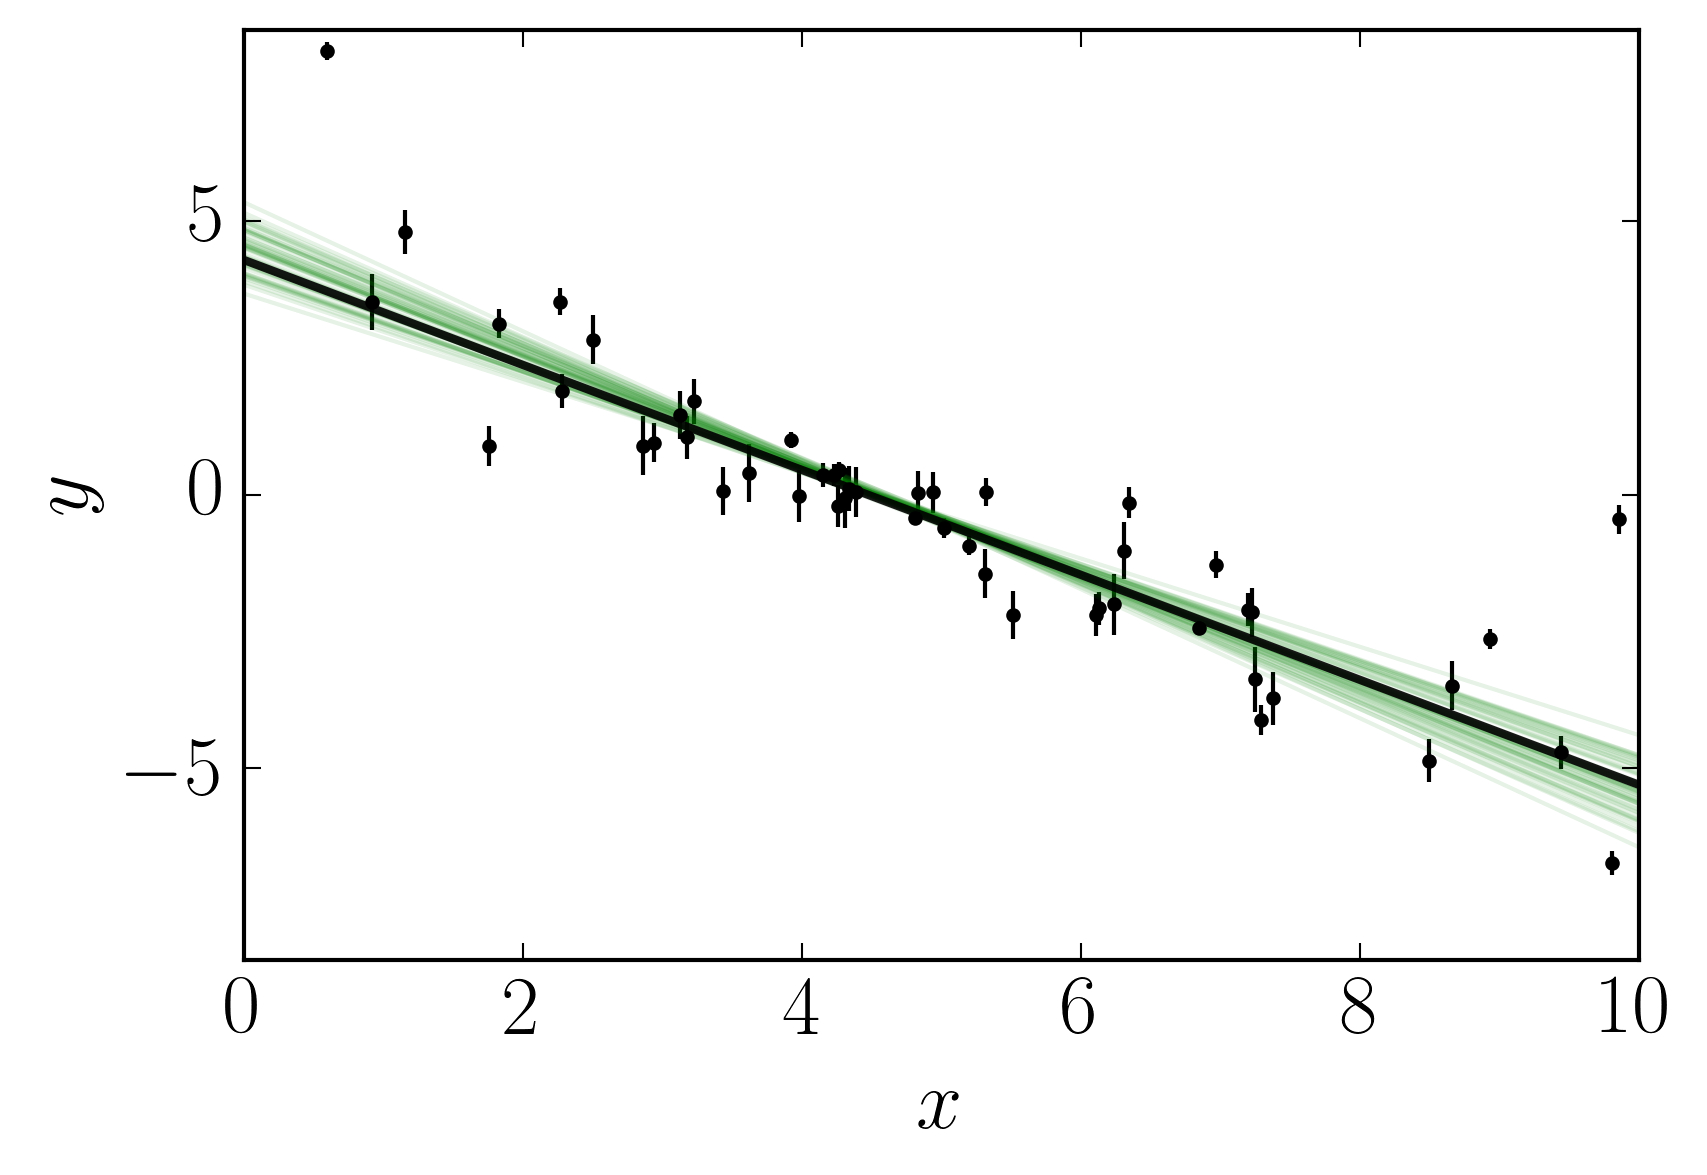

In [13]:
for i in np.random.randint(len(flatchain), size=50):
    m, b, _ = flatchain[i]
    pl.plot(x0, m * x0 + b, "g", alpha=0.1)
plot_data()

This leaves us with one question: which numbers should go in the abstract? There are a few different options for this but my favorite is to quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions. To compute these numbers for this example, you would run:

In [14]:
q = np.percentile(flatchain, [16, 50, 84], axis=0)
mean = q[1]
uncert = np.diff(q, axis=0).T

for i, (nm, truth) in enumerate(zip(("m", "b", "\ln f"),
                                    (m_true, b_true, np.log(f_true)))):
    display(Math(r"{0}_\mathrm{{MCMC}} = {1:.3f} _{{-{2:.3f}}}^{{+{3:.3f}}} \quad (\mathrm{{truth:}}\,{4:.3f})"
                 .format(nm, mean[i], uncert[i][0], uncert[i][1], truth)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Which isn't half bad when compared to the true values!

**emcee3** comes with many more advanced features that you can find described in these documentation pages but this should be enough to get you started.